# Intro

Generating truly random vectors, rotations, and more in 3 dimensions is possibly more challenging than you might think... Often the simple approach biases towards certain directions more than others.

This entire post is a jupyter notebook, in python, and is available for download [on the github for this site](https://github.com/oisincar/imois.in/tree/src/posts). Hopefully you find it useful!

Anyway... Lets start with some imports:

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import rand, normal
import scipy
from scipy.spatial.transform import Rotation as R

Next, we'll need some way to visualise if we're doing stuff correctly! This function graphs given points in a few ways, and will let us see if we're really choosing things randomly. It'll all make sense in a bit!

In [38]:
def plot_3d_vecs(vs):
    if type(vs) == list:
        vs = np.array(vs)
        
    fig = plt.figure(figsize=(10,10))

    _plot_2d_arrows(vs, 1)
    _plot_2d_histogram(vs, 2, 'z')
    _plot_2d_histogram(vs, 3, 'x')

    #_plot_3d_points(vs, 3)
    
    plt.tight_layout()

    plt.show()
    
def _plot_2d_arrows(vs, plot_ix):
    # Plot arrows for the first 1000 or so, projected in 2d
    ax = plt.subplot(1, 3, plot_ix)
    ax.set_title('100 vecs plotted in 3D')
    
    ax.set_aspect('equal', adjustable='box')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    [ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1) for (x,y,z) in vs[:100]]
    
def _plot_2d_histogram(vs, plot_ix, axis='x'):
    # Histogram of angles, also projected in 2d
    ax = plt.subplot(1, 3, plot_ix, projection='polar')
    ax.set_title(f'Histogram of angles about {axis} axis')
    
    if axis == 'x':
        angles = [np.arctan2(z, y) for (x,y,z) in vs]
    if axis == 'y':
        angles = [np.arctan2(x, z) for (x,y,z) in vs]
    if axis == 'z':
        angles = [np.arctan2(y, x) for (x,y,z) in vs]

    ax.hist(angles, bins=100)

def _plot_3d_points(vs, plot_ix):
    # Plot the points on a sphere.
    ax = plt.subplot(1, 3, plot_ix, projection='3d')
    ax.set_title('300 pts shown on a sphere')

    # Plot a sphere
    phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

    # Plot data
    data = vs[:300]*1.05
    xx, yy, zz = np.hsplit(data, 3) 
    ax.scatter(xx, yy, zz, color="k", s=20)

    # Matplotlib actually sucks - removed set_axis equal for 3d plots... so have to make
    # spheres look roughly spherical by this bs now ;-;
    r = 1.3
    ax.set_xlim([-r,r])
    ax.set_ylim([-r,r])
    ax.set_zlim([-1,1])

# Random Directions (Normal Vectors)


## normalize(rand(), rand(), rand())
The simple/obvious solution is to simply generate 3 numbers between -1 and 1, and normalize it. Surely that's a random vector...

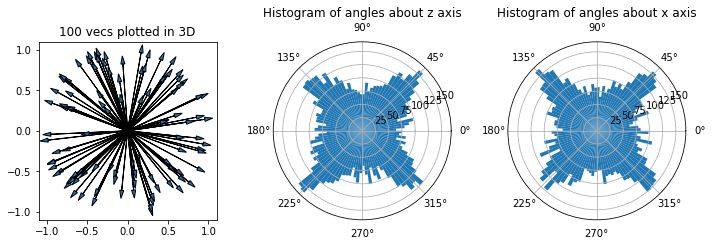

In [39]:
def rand_vec0():
    v = rand(3) * 2 - 1     # Random vec with values in range [-1, 1)
    v /= np.linalg.norm(v)  # Random normal vector??
    return v
    
# Make a load of 'random' vectors. 
vs = [rand_vec0() for i in range(10000)]
plot_3d_vecs(vs)

There's a problem here; this method biases towards diagonal vectors. In the central plot, it seems like vectors near the axes are around 2/3rds as likely to be chosen as their diagonal counterparts. The difference is due to how these points are sampled - we take a random point in a cube and normalize it. There's far more 'space' along the diagonals, hence the skew.

## Sampling within the unit circle

A simple way to fix it is to ignore points in this 'extra space', repeating until we have a point inside the unit circle instead.

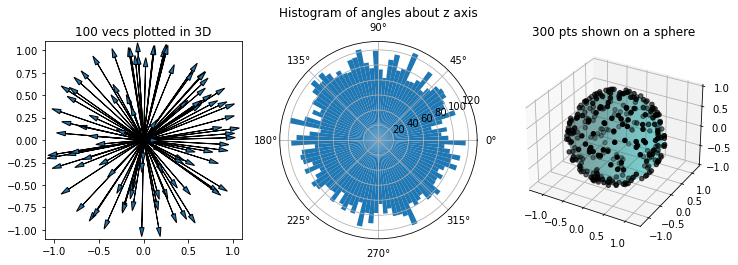

In [4]:
def rand_vec1():
    while True:
        v = np.random.rand(3) * 2 - 1  # Random vec with values in range [-1, 1)
        l = np.linalg.norm(v)          # Magnitude of v
        if l <= 1:
            v /= l                     # Random normal vector??
            return v
    
vs = [rand_vec1() for i in range(10000)]
plot_3d_vecs(vs)

Much better! There looks like an equal chance of 'choosing' a vector in any direction now. Still, the chance we discard a vector is $1 - \frac{4}{3}\pi0.5^2 \approx 0.47$. This means we'll often have to go through multiple iterations. Surely there's a better way...

## Polar Coordinates
There are several shadertoys which employ a random vector generation algorithm as part of a diffuse lighting model (https://www.shadertoy.com/view/lssfD7, https://www.shadertoy.com/view/3tsyzl). In both it forms part of the lambertNoTangent() function. The use here makes sense as the algorithm is quick - requiring two rand() operations and no branching (it does use a sin/cos, though).

The method samples a point on a sphere using polar coordinates.

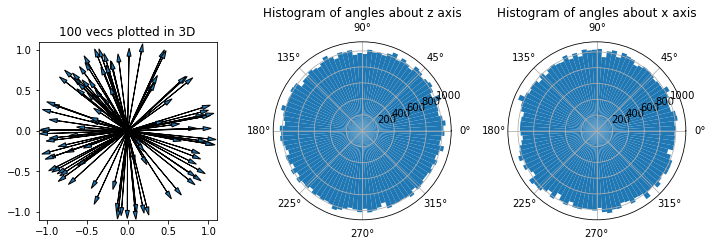

In [41]:
def rand_vec_polar():
    theta = rand() * 2 * np.pi  # [0, 2pi]
    y = rand() * 2 - 1          # [-1, 1]
    k = np.sqrt(1-y*y)
    return [k*np.cos(theta), k*np.sin(theta), y]
    
vs = [rand_vec1() for i in range(100000)]
plot_3d_vecs(vs)

## Normal Distribution
If we use the values of the vector with a normal distribution, we can simply normalize to get a random vector.
This is due to a neat property of the normal distribution - it's rotationally invariant. 

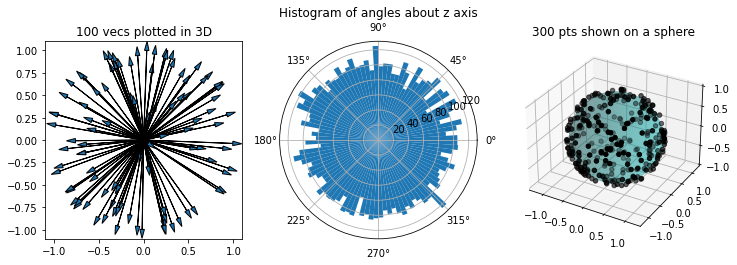

In [5]:
def rand_vec3():
    v = normal(size=3)      # Random vec w/ normally distributed values.
    v /= np.linalg.norm(v)  # Normalized = Random normal vector!?
    return v

# Make a load of 'random' vectors.
vs = [rand_vec3() for i in range(10000)]
plot_3d_vecs(vs)

# Uniform-random rotations
First, lets think about what a random rotation is. In 2 dimensions, rotations rotate an object by some angle from $0$ to $2\pi$, and it makes sense that a uniform-random rotation should be uniformly distributed over this range. In 3 dimensions/ euler angles this is no longer true though (as we'll see). We need a better definition.

Instead we can use the group-theoritic definition - that the distribution is unchanged by composition with arbitrary rotations.

In english (and very loosely) this is saying... Say we have a way to generate uniform-random rotations, and this has some distribution... If we apply any arbitrary rotation to these generated rotations, the distribution will remain the same.

For the sake of visualisation, we'll use a simpler 'sanity check'. A random rotation should rotate a fixed vector to point in any direction with equal probability. This is implied by the previous, when considering that a rotation can be represented by a basis.

## Euler angles
What happens if we just choose uniform-random elements of some euler angles?

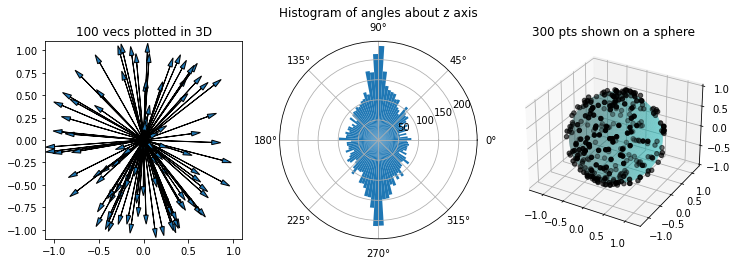

In [6]:
vs = []
for i in range(10000):
    r = R.from_euler('zyx', np.random.rand(3)*2*np.pi) # Random rotation?
    v = r.apply(np.array([0,1,0]))                     # Hence... Random vector?
    vs.append(v)

plot_3d_vecs(vs)

Oh no! We can see that 'randomly' rotating an up vector overwhelmingly leaves aligned with the starting y axis. This is because of an effect called gimbal lock, and the order the euler angles are applied. In fact, it is possible to choose a uniform-random rotation from euler angles; choosing the angles according to a specific PDF [(Miles, 1965)](https://www.jstor.org/stable/pdf/2333716.pdf)

$$g(\alpha, \beta, \gamma) = \frac{1}{8\pi^2} \sin \alpha, \;\;\; 0 \leq \alpha \leq \pi, 0 \leq \beta \lt 2\pi, 0 \leq \gamma \lt 2\pi$$

## Axis angle
Well we can create a random vector already... So is a uniform-random rotation just a rotation about a random axis by a random angle?

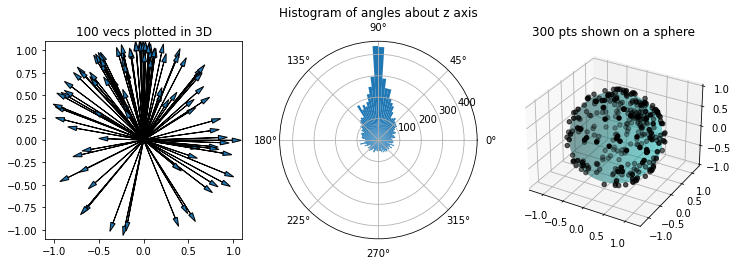

In [7]:
vs = []
for i in range(10000):
    ang = rand() * 2 * np.pi    # Random angle
    vec = rand_vec1()           # Random vector
    r = R.from_rotvec(ang*vec)  # = Random rotation?
    
    v = r.apply(np.array([0,1,0]))  # Hence... Random vector?
    vs.append(v)
    
plot_3d_vecs(vs)

Now the vectors are rarely changed far from their starting point?? Well, if the random axis chosen is close to the $y$ axis then the rotated vector will always remain close - regardless of the angle chosen. Again Miles has a PDF that corrects for this bias... But it's even more confusing than the previous. We define the rotation axis in terms of  a tuple; $(\theta, \phi)$. These are effectively euler angles, placing a point on the surface of a unit sphere. And an angle $V$, about which to rotate. The PDF is then given by:

$$g(V, \theta, \phi) = \frac{1}{2\pi^2}\sin^2{\frac{1}{2}V\sin{\theta}}$$

Where $0 \leq V \leq \pi, 0 \leq \theta \leq \pi, 0 \leq \phi < 2\pi$

## Gram-Schmidt
A rotation in 3D can be expressed as a rotation matrix - which is simply an orthagonal normal basis. Since we can generate normal vectors, we can use the Gram-Shmidt process to create a random basis. Note that we must use Gram-Schmidt; SVD or qr decomposition alone do _not_ produce an evenly distributed rotation.

A proof of the correctness of this approach is given in Multivariate statistics: a vector space approach, p234 [(Eaton, 1983)](https://www.worldcat.org/title/multivariate-statistics-a-vector-space-approach/oclc/9217654), or just verified below!

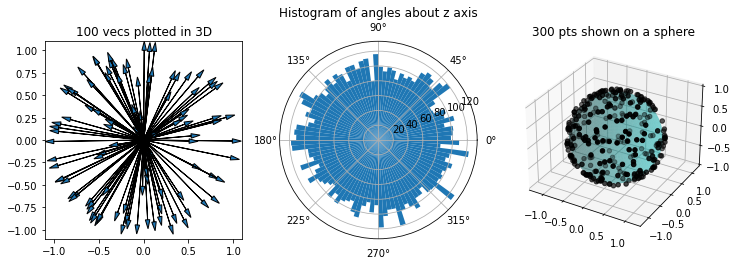

In [8]:
def gram_schmidt(A):
    for k in range(0, A.shape[1]):
        # Normalize
        A[:, k] /= np.linalg.norm(A[:, k])
        # Subtract from vecs below
        for j in range(k+1, A.shape[1]):
            r = np.dot(A[:, k], A[:, j])
            A[:, j] -= r*A[:, k]
    return A

# Change the handedness of the matrix. Converts from S(3) to SO(3)
def make_left(A):
    # If mat is right handed...
    if np.cross(A[0], A[1]).dot(A[2]) < 0:
        # Swap first two rows
        A[[0,1]] = A[[1,0]]
    return A

vs = []
for i in range(10000):
    m = normal(size=(3,3))  # Random mat w/ normal distribution components
    m = gram_schmidt(m)     # Random rotation mat?
    #m = scipy.linalg.orth(m) # Uses SVD: Not uniform!
    
    m = make_left(m)

    # Simply apply rotation mat directly
    v = m.dot(np.array([0,1,0])) # Hence, random vec?
    vs.append(v)

plot_3d_vecs(vs)

## QR Decomposition
Here's another way - using QR decomposition, which is based off of an algorithm for creating unitary matrices [(M. Ozols, 2009)](http://home.lu.lv/~sd20008/papers/essays/Random%20unitary%20[paper].pdf). We must choose a unique decomposition however, and arbitrarily pick the one which gives `r` a positive diagonal.

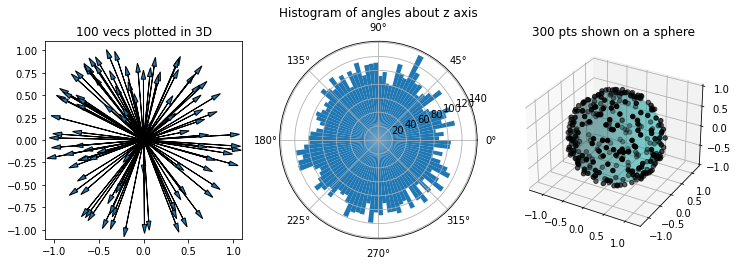

In [9]:
vs = []
for i in range(10000):
    m = normal(size=(3,3))  # Random mat w/ normal distribution components
    
    q, r = np.linalg.qr(m)  # QR decomposition
    
    # The qr decomposition with diag(r) positive is unique,
    # Since the numpy algorithm may (and does) bias, we find
    # this specific decomposition.
    s = np.sign(np.diag(r))
    r2 = r * s  # r2 has positive diagonal...
    # Compute corresponding q
    q2 = np.dot(m, np.linalg.inv(r2))
    
    # Normalize column vectors (we lost this in prev step)
    for i in range(3):
        q2[:, i] /= np.linalg.norm(q2[:, i])
    
    m = make_left(q2)  # q2 ~ S(3), m ~ SO(3)
    
    # Apply rotation mat directly to test point
    v = m.dot(np.array([0,1,0]))
    vs.append(v)
    
plot_3d_vecs(vs)

## Quaternions
And if that wasn't enough... Here's a final way using quaternions [(Shoemake, K., 1992)](https://doi.org/10.1016/B978-0-08-050755-2.50036-1). This is the simplest to implement but, imo, the hardest to understand. A normal sampling of a unitary quaternion is in fact a uniform-random rotation! It's worth noting that this, unlike the previous methods, only works in 3 dimensions.

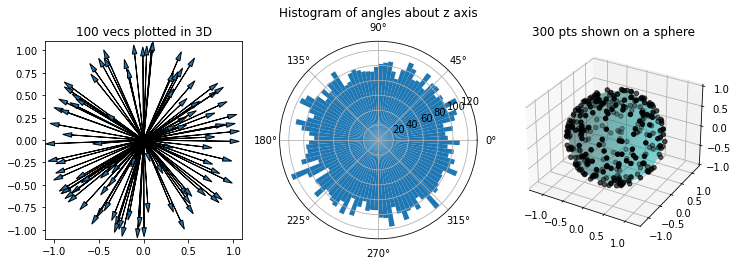

In [10]:
vs = []
for i in range(10000):
    q = normal(size=(4))
    q /= np.linalg.norm(q) # Unit-random unit quaternion?
    
    r = R.from_quat(q)
    v = r.apply(np.array([0,1,0]))  # Hence... Random vector?
    vs.append(v)

plot_3d_vecs(vs)